
# **Simulación de Descarga de Buques en Puerto con Camiones**
Programa permite generar simulaciones para modelar la operación de descarga de buques en un puerto, incluyendo la posibilidad de transferencia de carga a una bodega intermedia mediante una flota de camiones dedicados. 

## **1. Archivos y parametros**


- Importamos librerias necesarias
- Definimos parametros que rigen las operaciones del puerto
- Se cargan los datos de la operaciones desde el 2020 hasta el 2024, pero utilizaremos  solo los ultimos 3 años de los datos de buques y camiones para que la informacion este actualizada
- Se obtienen las tasas de llegada de buques y camiones para modelar la llegada con tiempos entre llegadas exponencial 


In [1]:
!pip install prettytable --quiet
!pip install seaborn --quiet
!pip install matplotlib --quiet

/Users/ignaciagothe/Desktop/Simulacion Puerto UI/.venv/bin/pip: line 2: /Users/ignaciagothe/Ignacia macbook/Trabajo/TRABAJO/Trabajo - ELogis/Simulacion/Todo/simulacion_abril_2025 2/.venv/bin/python: No such file or directory
/Users/ignaciagothe/Desktop/Simulacion Puerto UI/.venv/bin/pip: line 2: exec: /Users/ignaciagothe/Ignacia macbook/Trabajo/TRABAJO/Trabajo - ELogis/Simulacion/Todo/simulacion_abril_2025 2/.venv/bin/python: cannot execute: No such file or directory
/Users/ignaciagothe/Desktop/Simulacion Puerto UI/.venv/bin/pip: line 2: /Users/ignaciagothe/Ignacia macbook/Trabajo/TRABAJO/Trabajo - ELogis/Simulacion/Todo/simulacion_abril_2025 2/.venv/bin/python: No such file or directory
/Users/ignaciagothe/Desktop/Simulacion Puerto UI/.venv/bin/pip: line 2: exec: /Users/ignaciagothe/Ignacia macbook/Trabajo/TRABAJO/Trabajo - ELogis/Simulacion/Todo/simulacion_abril_2025 2/.venv/bin/python: cannot execute: No such file or directory
/Users/ignaciagothe/Desktop/Simulacion Puerto UI/.venv/b

In [2]:
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:

# ========================
#    Librerias
# ========================
# %pip install scipy --quiet

from numpy.random import choice
import simpy
import pandas as pd
import numpy as np
import random
from scipy.stats import lognorm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
# from prettytable import PrettyTable


# =======================================
#    Parámetros básicos de operación
#       Se pueden modificar
# ========================================

TIEMPO_PUERTA_SALIDA = 8.16        # (minutos)
TIEMPO_PUERTA_ENTRADA = 2       # (minutos)
TIEMPO_CARGAR_EN_CHUTE = 7.28     # (minutos)
TIEMPO_ATRAQUE = 462  # (minutos)
TIEMPO_LLEGADA_CAMIONES = 440
# (factor de ajuste de la tasa de llegada de buques)
TASA_LLEGADA_FACTOR = 1.08

TIEMPO_A_BODEGA = 3             # (minutos)
TIEMPO_DESCARGAR_EN_BODEGA = 6  # (minutos)
TIEMPO_CARGAR_EN_BODEGA = 6     # (minutos)

TIEMPO_ENTRADA_CAMION_DEDICADO = 2  # (minutos)
TIEMPO_SALIDA_DE_BODEGA = 2         # (minutos)
MAXIMO_RADA = 8

In [4]:
%pip install openpyxl --quiet


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
buques = pd.read_excel('naves_epic.xlsx')
buques

,operacion,nave,arribo,primera_espia,inicio_descarga,fin_descarga,ultima_espia,tonelaje,total_falta_equipos,total_detenciones,tiempo_descarga,tiempo_de_espera,horas_muellaje,tiempo_entre_arribos,n,cliente,año
0,2021002,FOUR OTELLO,2021-01-02 06:00:00,2021-01-03 08:15:00,2021-01-03 10:20:00,2021-01-05 17:55:00,2021-01-06 09:10:00,32411.80,81.383333,15.085556,55.583333,26.250000,72.916667,85.700000,2,1,2021
1,2021003,AQUATA,2021-01-09 21:50:00,2021-01-10 11:10:00,2021-01-10 13:25:00,2021-01-13 15:10:00,2021-01-13 16:45:00,36506.14,94.200000,7.744722,73.750000,13.333333,77.583333,183.833333,3,2,2021
2,2021004,TAMARACK,2021-01-19 23:40:00,2021-01-20 10:45:00,2021-01-20 12:50:00,2021-01-23 13:45:00,2021-01-23 16:20:00,35539.27,57.466667,7.098611,72.916667,11.083333,77.583333,241.833333,4,2,2021
3,2021005,DORTHE OLDENDORFF,2021-01-20 11:00:00,2021-01-23 17:40:00,2021-01-23 20:00:00,2021-01-25 18:30:00,2021-01-25 19:55:00,28621.53,50.400000,5.366111,46.500000,78.666667,50.250000,11.333333,5,1,2021
4,2021006,BRITTA OLDENDORFF,2021-01-22 10:00:00,2021-01-25 21:05:00,2021-01-25 22:45:00,2021-01-28 15:15:00,2021-01-28 16:55:00,35677.74,80.516667,8.666667,64.500000,83.083333,67.833333,47.000000,6,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,2024083,SANYU,2024-11-30 21:05:00,2024-12-08 00:30:00,2024-12-08 03:15:00,2024-12-11 21:10:00,2024-12-11 22:50:00,48319.44,13.316667,13.502222,89.916667,171.416667,94.333333,76.383333,83,8,2024
325,2024084,SKATSOURA,2024-12-10 23:00:00,2024-12-12 04:20:00,2024-12-12 12:45:00,2024-12-17 02:10:00,2024-12-17 04:25:00,36630.31,60.183333,30.055278,109.416667,29.333333,120.083333,241.916667,84,1,2024
326,2024085,GOLDEN SAKURA,2024-12-12 15:18:00,2024-12-17 05:55:00,2024-12-17 08:45:00,2024-12-21 15:25:00,2024-12-21 16:50:00,52979.36,5.616667,17.038056,102.666667,110.616667,106.916667,40.300000,85,2,2024
327,2024086,PARIS TRADER,2024-12-13 15:30:00,2024-12-22 07:00:00,2024-12-22 09:40:00,2024-12-26 11:30:00,2024-12-26 13:15:00,35038.55,84.650000,37.848611,97.833333,207.500000,102.250000,24.200000,86,2,2024


In [6]:


# =======================================
#    Datos Historicos Camiones y Buques
# ========================================

camiones = pd.read_csv('camiones1.csv')
camiones = camiones[camiones['año'] > 2022]
camiones = camiones[camiones['capacidad'] > 20]
tasa_llegada = 1/(camiones.groupby('turno')['min_entre_camiones'].mean())
tasas_llegada = tasa_llegada.to_dict()

buques = pd.read_excel('naves_epic.xlsx')
buques = buques[buques['tiempo_descarga'] < 140]
buques = buques[buques['tiempo_descarga'] > 30]
buques = buques[buques['tiempo_entre_arribos'] < 450]
buques['espera_sin_detenciones_externas'] = (
    buques['tiempo_de_espera']-buques['total_detenciones'])
buques['horas_delay'] = (buques['inicio_descarga'] -
                         buques['primera_espia']).dt.total_seconds()/3600
buques['minutos_delay'] = buques['horas_delay']*60
buques['dias_delay'] = buques['horas_delay']/24
# buques.loc[buques['espera_sin_detenciones_externas'] < 0, 'espera_sin_detenciones_externas'] = 0

buques = buques[-250:]
buques['horas_de_espera'] = buques['tiempo_de_espera'].copy()
buques['horas_de_descarga'] = buques['tiempo_descarga'].copy()
buques['horas_detencion'] = buques['total_detenciones'].copy()
buques['horas_entre_arribos'] = buques['tiempo_entre_arribos'].copy()
buques['horas_falta_equipos'] = buques['total_falta_equipos'].copy()
buques['Dias_de_espera_buque'] = buques['tiempo_de_espera']/24
buques['Dias_de_descarga_buque'] = buques['tiempo_descarga']/24
buques['Dias_detencion_buque'] = buques['total_detenciones']/24
buques['Dias_entre_arribos_buque'] = buques['tiempo_entre_arribos']/24
buques['Dias_falta_equipos_buque'] = buques['total_falta_equipos']/24
buques['Dias_espera_2'] = buques['espera_sin_detenciones_externas']/24
buques['tiempo_de_espera'] = buques['tiempo_de_espera']*60
buques['tiempo_descarga'] = buques['tiempo_descarga']*60
buques['total_detenciones'] = buques['total_detenciones']*60
buques['minutos_entre_arribos'] = buques['tiempo_entre_arribos']*60
buques['total_falta_equipos'] = buques['total_falta_equipos']*60

tasa_llegada_buques = 1/(buques['minutos_entre_arribos'].mean())

tasa_llegada_buques = tasa_llegada_buques*TASA_LLEGADA_FACTOR  # tasa

# ignorar:
# data = buques['minutos_entre_arribos']
# loc, scale = stats.expon.fit(data, floc=0)
# log_data = np.log(data)
# mu, sigma = stats.norm.fit(log_data)


def determinar_turno(hora):
    if 8 <= hora < 16:
        return 1
    elif 16 <= hora < 24:
        return 2
    else:
        return 3

In [7]:
buques['Dias_entre_arribos_buque'].mean()

np.float64(4.177452777777777)

In [8]:
tasa_llegada_buques*60*24

np.float64(0.25853075006499837)



### **Histogramas datos historicos**


In [9]:
buques[buques['dias_delay'] < 0]

,operacion,nave,arribo,primera_espia,inicio_descarga,fin_descarga,ultima_espia,tonelaje,total_falta_equipos,total_detenciones,...,horas_detencion,horas_entre_arribos,horas_falta_equipos,Dias_de_espera_buque,Dias_de_descarga_buque,Dias_detencion_buque,Dias_entre_arribos_buque,Dias_falta_equipos_buque,Dias_espera_2,minutos_entre_arribos
259,2024014,PACIFIC ETERNITY…,2024-01-29 07:18:00,2024-02-13 08:30:00,2024-02-03 01:30:00,2024-02-07 03:05:00,2024-02-18 07:25:00,53233.37,5868.0,1593.816667,...,26.563611,90.3,97.8,15.05,4.065972,1.106817,3.7625,4.075,13.943183,5418.0


In [10]:
buques = buques[buques['dias_delay'] > 0]
buques = buques[buques['dias_delay'] < 0.5]

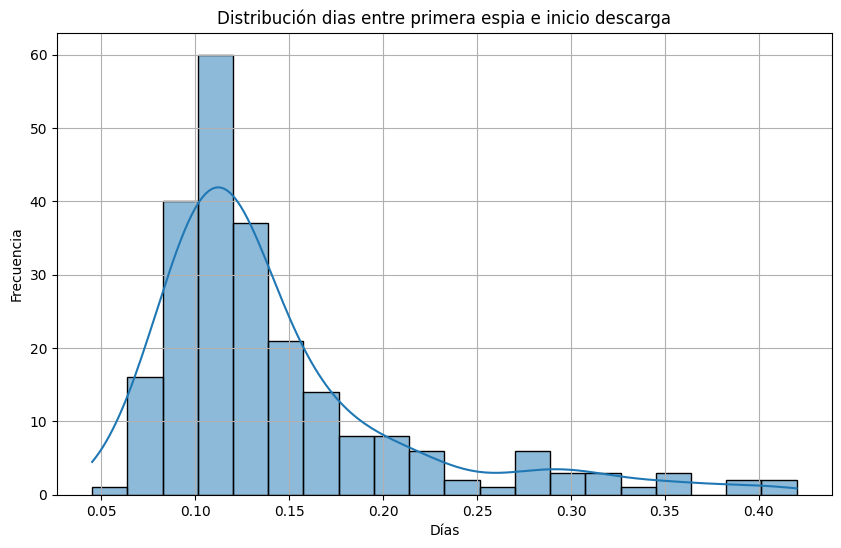

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(buques['dias_delay'], bins=20, kde=True)
plt.title('Distribución dias entre primera espia e inicio descarga')
plt.xlabel('Días')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

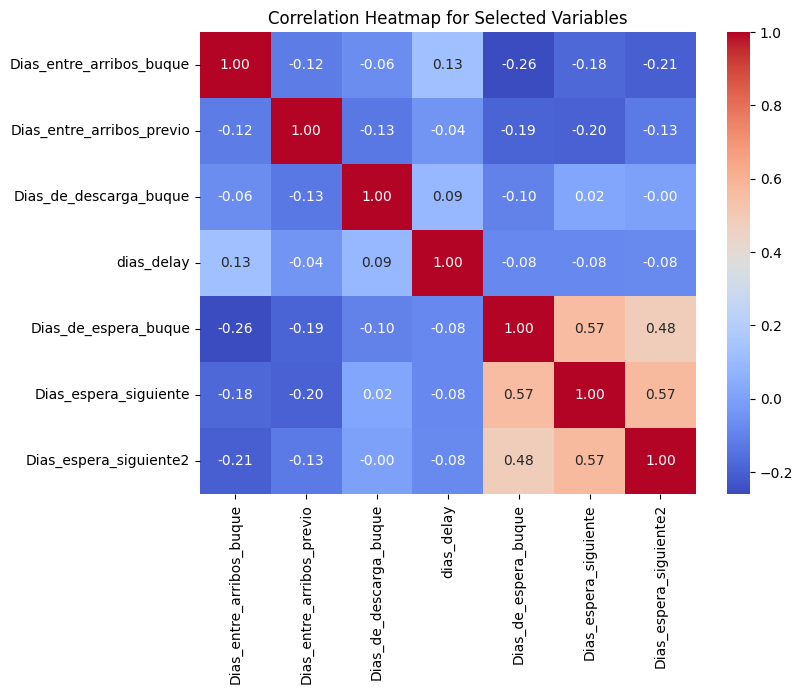

In [12]:
# Select the relevant columns

buques['Dias_espera_siguiente'] = buques['Dias_de_espera_buque'].shift(-1)
buques['Dias_espera_siguiente2'] = buques['Dias_de_espera_buque'].shift(-2)
buques['Dias_entre_arribos_previo'] = buques['Dias_entre_arribos_buque'].shift(
    1)

correlation_data = buques[['Dias_entre_arribos_buque', 'Dias_entre_arribos_previo', 'Dias_de_descarga_buque', 'dias_delay',
                           'Dias_de_espera_buque', 'Dias_espera_siguiente', 'Dias_espera_siguiente2']].dropna()

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True,
            cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap for Selected Variables')
plt.show()

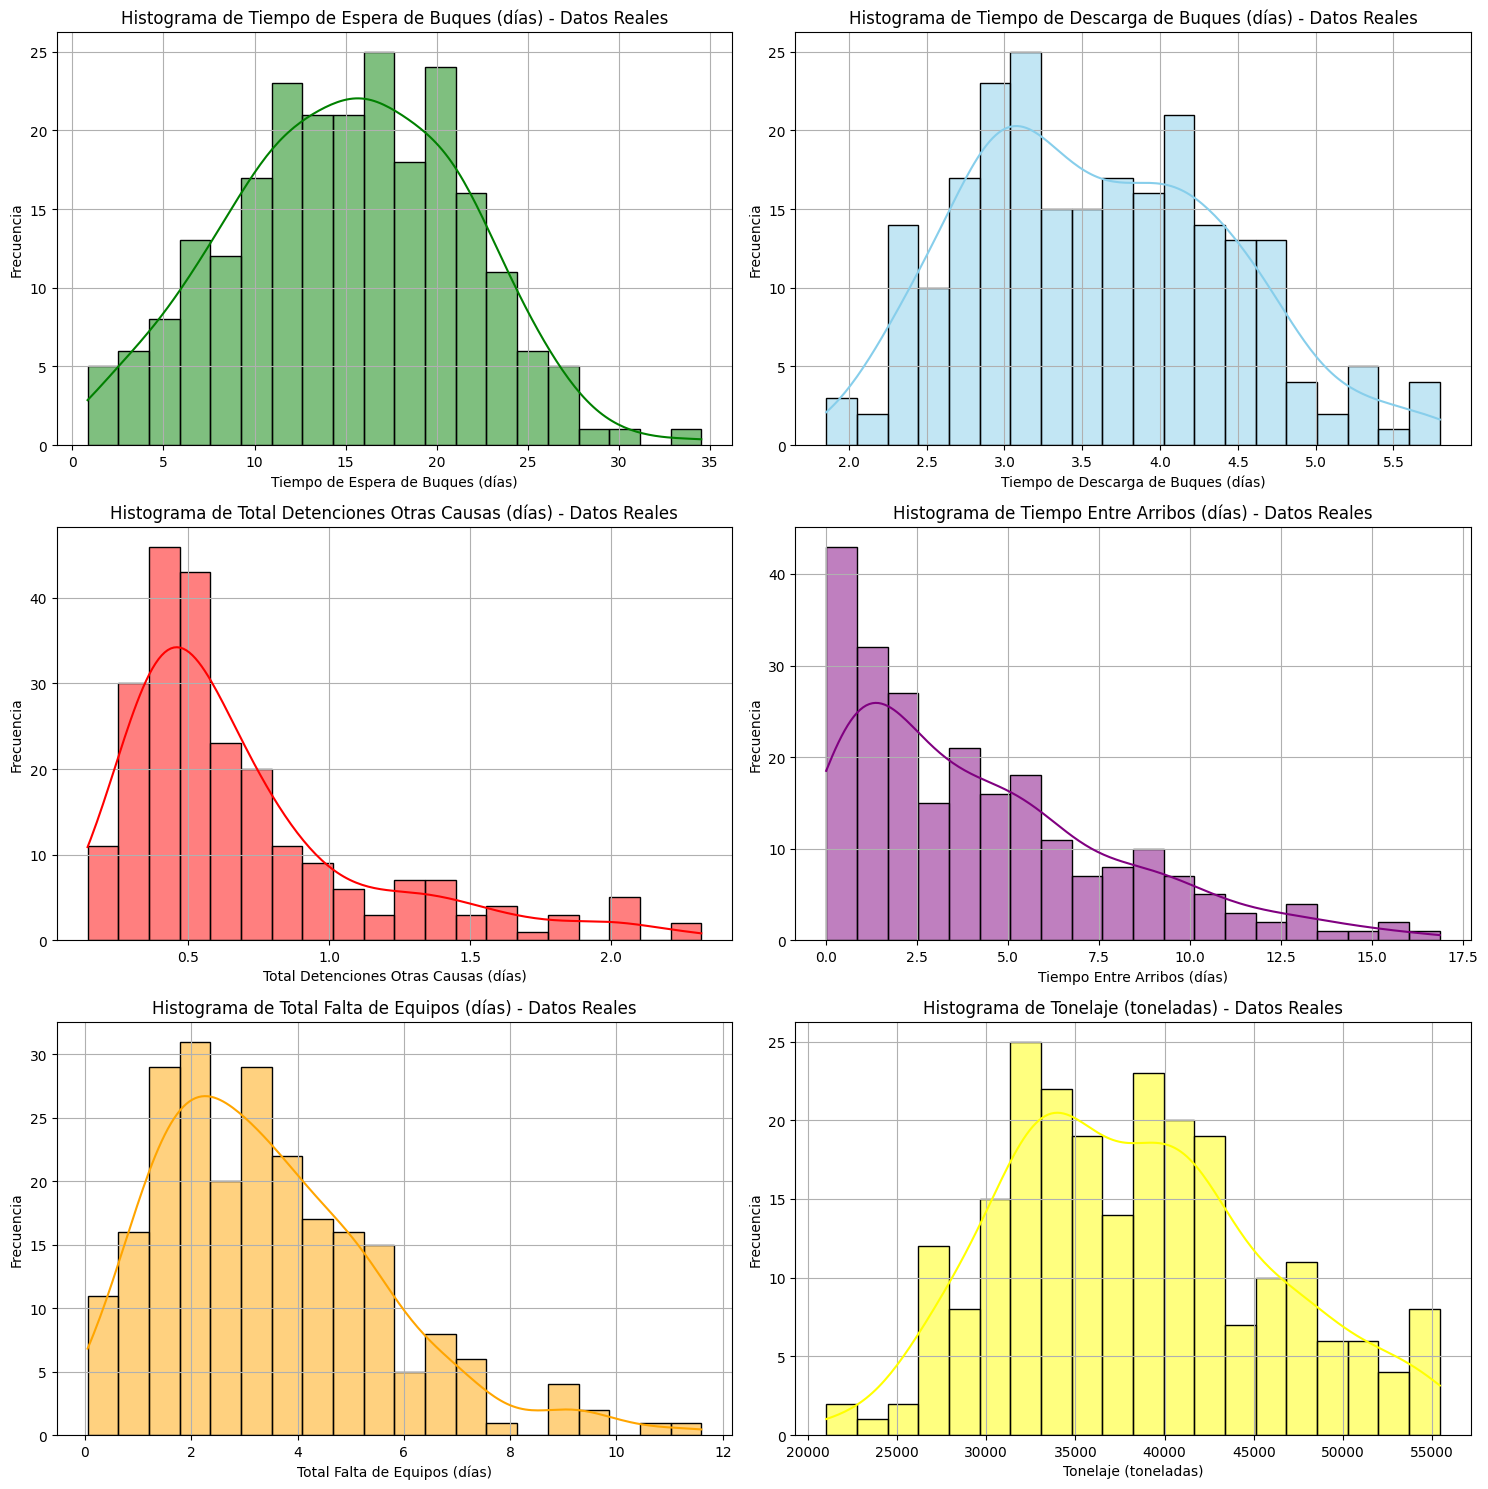

In [13]:
buques = buques[buques['dias_delay'] > 0]
buques = buques[buques['dias_delay'] < 0.5]
# ===============================================
#    Histogramas datos reales operaciones
# ================================================
colores = ['green', 'skyblue', 'red', 'purple', 'orange', 'yellow']
columnas_histogramas = ['Dias_de_espera_buque', 'Dias_de_descarga_buque',
                        'Dias_detencion_buque', 'Dias_entre_arribos_buque', 'Dias_falta_equipos_buque', 'tonelaje']

titulos_histogramas = ['Tiempo de Espera de Buques (días)',
                       'Tiempo de Descarga de Buques (días)',
                       'Total Detenciones Otras Causas (días)',
                       'Tiempo Entre Arribos (días)',
                       'Total Falta de Equipos (días)', 'Tonelaje (toneladas)']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))


for i, col in enumerate(columnas_histogramas):
    row, col_idx = divmod(i, 2)
    sns.histplot(buques[col], bins=20, kde=True,
                 color=colores[i], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(
        f'Histograma de {titulos_histogramas[i]} - Datos Reales', fontsize=12)
    axes[row, col_idx].set_xlabel(titulos_histogramas[i], fontsize=10)
    axes[row, col_idx].set_ylabel('Frecuencia', fontsize=10)
    axes[row, col_idx].grid(True)

if len(columnas_histogramas) % 2 != 0:
    fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

## **2. Modelo**




### **Clases**




Aquí se definen las clases que representan los recursos y entidades del sistema:
- **Puerto**: Contiene recursos (frente de atraque, puertas, chutes) y algunos eventos importantes.
- **Bodega**: Modela la bodega de almacenamiento de grano.
- **Buque**: Representa a cada buque que llega y solicita el uso del muelle.
- **Camión**, **CamiónDedicado**, **CamiónBodega**: Modelan los distintos tipos de camiones y sus procesos de carga y descarga.



In [14]:

# =====================================
#   Clases
# =====================================

class Puerto:
    def __init__(self, env):
        self.env = env
        self.frente_atraque = simpy.Resource(env, capacity=1)
        self.puerta_entrada = simpy.Resource(env, capacity=1)
        self.puerta_salida = simpy.Resource(env, capacity=1)
        self.chutes = simpy.Resource(env, capacity=5)
        self.grano_muelle = simpy.Container(env, init=0)
        self.iniciar_llegada_camiones = env.event()
        self.inicio_descarga_evento = env.event()
        self.fin_descarga_evento = env.event()
        self.falta_camiones_event = env.event()
        self.buques_peridos = 0
        self.current_buque = None
        self.arribo_buque_evento = env.event()
        self.buques_atendidos = []
        self.datos_rada = []

    def monitor_cola_camiones(self, env: simpy.Environment):
        """
        Monitorea la cola de camiones en la puerta de entrada.
        Si no hay camiones, dispara un evento indicando falta de camiones.
        """
        while True:
            if len(self.puerta_entrada.users) == 0 and len(self.puerta_entrada.queue) == 0:
                self.falta_camiones_event.succeed()
                self.falta_camiones_event = env.event()
            yield env.timeout(0.5)


class Bodega:
    def __init__(self, env, grano_bodega_init):
        self.env = env
        self.grano_bodega = simpy.Container(env, init=grano_bodega_init)
        self.cargar_en_bodega = simpy.Resource(env, capacity=1)
        self.descargar_en_bodega = simpy.Resource(env, capacity=1)
        self.bodega_recargada = env.event()
        self.eventos_bodega = []
        if grano_bodega_init > 0:
            self.bodega_recargada.succeed()
            self.bodega_recargada = env.event()


class Buque:
    def __init__(self, env, puerto: Puerto, id_buque, tonelaje):
        self.env = env
        self.id_buque = id_buque
        self.tonelaje = tonelaje
        self.puerto = puerto
        self.num_camiones_normales = 0
        self.num_camiones_dedicados = 0
        self.largo_cola_al_arribar = len(puerto.frente_atraque.queue)

    def proceso_buque(self, env, puerto):
        """
        Proceso que maneja la llegada de un buque, el atraque,
        la espera y la descarga.
        """
        self.arribo = env.now
        with puerto.frente_atraque.request() as request_muelle:
            yield request_muelle

            yield env.timeout(TIEMPO_LLEGADA_CAMIONES)

            puerto.current_buque = self

            # Iniciar la llegada de camiones:
            puerto.iniciar_llegada_camiones.succeed()
            puerto.iniciar_llegada_camiones = env.event()

            yield env.timeout(TIEMPO_ATRAQUE-TIEMPO_LLEGADA_CAMIONES)
            # fin de atraque, comienza descarga

            self.primera_espia = env.now
            self.tiempo_espera = self.primera_espia - self.arribo

            yield env.timeout(choice(buques['minutos_delay'].values))

            # Cargar el grano en el muelle
            yield puerto.grano_muelle.put(self.tonelaje)

            puerto.inicio_descarga_evento.succeed()
            puerto.inicio_descarga_evento = env.event()
            self.inicio_descarga = env.now
            # Esperar a que se dispare el evento de fin de descarga
            yield puerto.fin_descarga_evento
            puerto.current_buque = None
            self.tiempo_descarga = env.now - self.inicio_descarga

            puerto.buques_atendidos.append(self)


class Camion:
    def __init__(self, env, id_camion, capacidad, puerto: Puerto):
        self.env = env
        self.id = id_camion
        self.capacidad = capacidad
        self.carga = 0
        self.puerto = puerto
        self.proceso = env.process(self.proceso_camion(env, puerto))

    def proceso_camion(self, env,  puerto: Puerto):
        """
        Proceso del camión normal que entra por la puerta,
        solicita chute y carga desde el muelle, luego sale por la puerta de salida.
        """
        req_puerta_entrada = puerto.puerta_entrada.request()
        yield req_puerta_entrada
        yield env.timeout(TIEMPO_PUERTA_ENTRADA/2)
        with puerto.chutes.request() as req_chute:
            yield req_chute
            yield env.timeout(TIEMPO_PUERTA_ENTRADA/2)

            puerto.puerta_entrada.release(req_puerta_entrada)

            # Verificación de pausa en caso de horario de colación (ejemplo simple)
            current_time = env.now % 1440
            if 780 <= current_time < 840:
                yield env.timeout(840 - current_time)
            elif 420 <= current_time < 480:
                yield env.timeout(480 - current_time)
            elif 900 <= current_time < 960:
                yield env.timeout(960 - current_time)
            elif 1380 <= current_time < 1440:
                yield env.timeout(1440 - current_time)

            # Esperar a que comience la descarga si no hay buque o no hay grano
            if puerto.grano_muelle.level == 0 or puerto.current_buque == None:
                yield puerto.inicio_descarga_evento

            # Carga mínima entre la capacidad del camión y lo disponible en muelle
            carga = min(self.capacidad,  puerto.grano_muelle.level)
            yield puerto.grano_muelle.get(carga)
            self.carga = carga
            puerto.current_buque.num_camiones_normales += 1

            # Si ya no queda grano y todavía está en curso la descarga del buque,
            # se dispara el evento fin de descarga
            if puerto.grano_muelle.level == 0 and not puerto.fin_descarga_evento.triggered:
                puerto.fin_descarga_evento.succeed()
                puerto.fin_descarga_evento = env.event()

            yield env.timeout(TIEMPO_CARGAR_EN_CHUTE)
        req_puerta_salida = puerto.puerta_salida.request()
        yield req_puerta_salida

        puerto.puerta_salida.release(req_puerta_salida)


class CamionDedicado:
    def __init__(self, env, id_camion, capacidad, puerto: Puerto, bodega: Bodega):
        self.env = env
        self.id = id_camion
        self.capacidad = capacidad
        self.puerto = puerto
        self.bodega = bodega
        self.carga = 0
        self.proceso = env.process(
            self.proceso_camion_dedicado(env, puerto, bodega))

    def proceso_camion_dedicado(self, env, puerto, bodega):
        """
        El camión dedicado viaja repetidamente entre el muelle y la bodega.
        Solo parte cuando no hay camiones normales disponibles y se requiere traslado.
        """
        while True:
            # Esperar hasta que se dispare el evento de falta de camiones
            esperar = True
            while esperar:
                yield puerto.falta_camiones_event
                yield env.timeout(2)  # Pequeña demora adicional
                if len(puerto.puerta_entrada.users) == 0 and len(puerto.puerta_entrada.queue) == 0:
                    esperar = False

            # Entra al muelle
            req_puerta = puerto.puerta_entrada.request()
            yield req_puerta

            yield env.timeout(TIEMPO_PUERTA_ENTRADA)

            with puerto.chutes.request() as req_chute:
                yield req_chute

                puerto.puerta_entrada.release(req_puerta)

                current_time = env.now % 1440
                if 780 <= current_time < 840:
                    yield env.timeout(840 - current_time)
                elif 420 <= current_time < 480:
                    yield env.timeout(480 - current_time)
                elif 900 <= current_time < 960:
                    yield env.timeout(960 - current_time)
                elif 1380 <= current_time < 1440:
                    yield env.timeout(1440 - current_time)

                # Si no hay grano o no hay buque, esperar el inicio de descarga
                if puerto.grano_muelle.level == 0 or puerto.current_buque == None:
                    yield puerto.inicio_descarga_evento

                carga = min(self.capacidad,  puerto.grano_muelle.level)
                yield puerto.grano_muelle.get(carga)
                self.carga = carga
                puerto.current_buque.num_camiones_dedicados += 1

                if puerto.grano_muelle.level == 0 and not puerto.fin_descarga_evento.triggered:
                    puerto.fin_descarga_evento.succeed()
                    puerto.fin_descarga_evento = env.event()

                yield env.timeout(TIEMPO_CARGAR_EN_CHUTE)

            # Traslado a la bodega
            yield env.timeout(TIEMPO_A_BODEGA)

            # Descarga en la bodega
            self.t_llegada_bodega = env.now
            with bodega.descargar_en_bodega.request() as req_bodega:
                yield req_bodega
                self.t_inicio_descarga_bodega = env.now

                yield env.timeout(TIEMPO_DESCARGAR_EN_BODEGA)
                yield bodega.grano_bodega.put(self.carga)
                if not bodega.bodega_recargada.triggered:
                    bodega.bodega_recargada.succeed()
                    bodega.bodega_recargada = env.event()

                self.carga_depositada = self.carga
                self.carga = 0
                self.fin_descarga = env.now

                self.tiempo_en_cola = self.t_inicio_descarga_bodega-self.t_llegada_bodega
                self.tiempo_descarga = self.fin_descarga-self.t_inicio_descarga_bodega

                bodega.eventos_bodega.append({
                    'id_camion': 'Dedicado'+str(self.id),
                    'horas en cola bodega': self.tiempo_en_cola/60,
                    'horas de descarga en bodega': self.tiempo_descarga/60,
                    'horas de carga en bodega': 0,
                    'actividad camion ': 'descargar en bodega',
                    'tons depositadas en bodega': self.carga_depositada,
                    'tons retiradas de bodega': 0,
                    'ton restante bodega': bodega.grano_bodega.level
                })

            yield env.timeout(TIEMPO_SALIDA_DE_BODEGA)


class CamionBodega:
    def __init__(self, env, id_camion_bodega, capacidad, bodega):
        self.env = env
        self.id = id_camion_bodega
        self.capacidad = capacidad
        self.carga = 0
        self.proceso = env.process(self.proceso_camion_bodega(env, bodega))

    def proceso_camion_bodega(self, env, bodega: Bodega):
        """
        Camión que se carga en la bodega y luego sale.
        """
        self.tiempo_llegada = env.now
        with bodega.cargar_en_bodega.request() as req_cargar_bodega:
            yield req_cargar_bodega
            self.inicio_carga = env.now

            # Espera si la bodega está vacía
            if bodega.grano_bodega.level == 0:
                yield bodega.bodega_recargada

            yield env.timeout(TIEMPO_CARGAR_EN_BODEGA)

            carga = min(self.capacidad,  bodega.grano_bodega.level)
            yield bodega.grano_bodega.get(carga)
            self.carga = carga
            self.fin_carga = env.now

            self.tiempo_en_cola = self.inicio_carga-self.tiempo_llegada
            self.tiempo_carga = self.fin_carga-self.inicio_carga

            bodega.eventos_bodega.append({
                'id_camion': 'Bodega'+str(self.id),
                'horas en cola bodega': self.tiempo_en_cola/60,
                'horas de descarga en bodega': 0,
                'horas de carga en bodega': self.tiempo_carga/60,
                'actividad camion ': 'cargar en bodega',
                'tons depositadas en bodega': 0,
                'tons retiradas de bodega': self.carga,
                'ton restante bodega': bodega.grano_bodega.level
            })

            yield env.timeout(TIEMPO_SALIDA_DE_BODEGA)



### **Funciones generadoras**



Se definen funciones para generar buques y camiones en el sistema de manera estocástica (según distribuciones exponenciales basadas en la tasa de llegada calculada).

Notas de implementacion:
 - De los camiones generados, un porcentaje se asigna como camiones normales (argumento `p`) y el resto como camiones normales.
 - La llegada de camoiones sigue un proceso de poisson con tasa variable segun la hora del dia
 - La cola de buques en la rada tiene un maximo de 12 buques, los buques que llegan cuando esta llena se van.



In [15]:

def generar_buques(env: simpy.Environment, puerto: Puerto):
    """
    Genera buques en el sistema basados en una tasa de llegada exponencial.
    """
    i_buques = 0
    while True:
        tiempo_entre_arribo = random.expovariate(tasa_llegada_buques)

        # tiempo_entre_arribo = stats.expon.rvs(loc=loc, scale=scale, size=1)[0]
        yield env.timeout(tiempo_entre_arribo)

        # Si la cola es muy larga, se asume que el buque se pierde
        if len(puerto.frente_atraque.queue) < MAXIMO_RADA:
            buque = Buque(env, puerto, i_buques, choice(buques['tonelaje']))
            env.process(buque.proceso_buque(env, puerto))
            i_buques += 1
        else:
            puerto.buques_peridos += 1


def generar_camiones_puerto(env, puerto, p):
    """
    Genera camiones normales que llegan al puerto para cargar. 
    La probabilidad `p` se utiliza para otras condiciones (ej: ir a bodega).
    """
    camion_puerto_id = 0
    while True:
        yield puerto.iniciar_llegada_camiones

        while puerto.current_buque is not None:
            hora = (env.now % 1440) // 60
            turno = determinar_turno(hora)
            if random.random() < 1-p:
                yield env.timeout(random.expovariate(tasa_llegada[turno]))

            # Ejemplo de uso de p (no se emplea aquí, pero se deja para posibles extensiones)
                Camion(env, camion_puerto_id, choice(
                    camiones['capacidad']), puerto)
                camion_puerto_id += 1


def generar_camiones_bodega(env, bodega, p):
    """
    Genera camiones que se cargan en la bodega. 
    La probabilidad `p` indica la probabilidad de que se generen estos camiones.
    """
    camion_bodega_id = 0
    while True:
        # Espera hasta que la bodega tenga algo de grano
        yield bodega.bodega_recargada

        while bodega.grano_bodega.level > 0:
            hora = (env.now % 1440) // 60
            turno = determinar_turno(hora)
            if random.random() < p:
                yield env.timeout(random.expovariate(tasa_llegada[turno]))

                CamionBodega(env, camion_bodega_id, choice(
                    camiones['capacidad']), bodega)
                camion_bodega_id += 1


def monitor_cola_buques(env, puerto: Puerto):
    """
    Monitorea la cola de buques en el muelle y guarda datos en puerto.datos_rada.
    """
    while True:
        yield env.timeout(60*24)
        tiempo = env.now
        buques_en_cola = len(puerto.frente_atraque.queue) + \
            len(puerto.frente_atraque.users)
        puerto.datos_rada.append({
            'Dia': tiempo // 1440,
            'Largo cola rada': buques_en_cola,
            'total buques atendidos': len(puerto.buques_atendidos),
            'total buques perdidos': puerto.buques_peridos
        })



### **Función simulacion**


In [16]:

def simulacion(años, camiones_dedicados=0, grano=0, cap=0, prob=0, buques_inicio_cola=7, seed=None):
    """
    Ejecuta la simulación con los parámetros proporcionados:
    - tiempo: tiempo total de simulación (minutos)
    - n: número de camiones dedicados
    - grano: capacidad inicial de la bodega
    - cap: capacidad de camiones dedicados
    - prob: probabilidad asociada a la generación de camiones para la bodega
    - buques_inicio_cola: cuántos buques se inician en la cola (inicial)

    Retorna:
    - df_buques: DataFrame con info de buques atendidos
    - df_cola: DataFrame con el monitoreo de la cola de buques
    - df_bodega (opcional): DataFrame con eventos de la bodega si n>0
    """
    tiempo = (365 * 24 * 60) * años

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    env = simpy.Environment()
    puerto = Puerto(env)

    env.process(generar_buques(env, puerto))
    env.process(generar_camiones_puerto(env, puerto, prob))
    env.process(monitor_cola_buques(env, puerto))

    for i in range(buques_inicio_cola):
        buque = Buque(env, puerto, i, choice(buques['tonelaje']))
        env.process(buque.proceso_buque(env, puerto))

    if camiones_dedicados > 0:
        bodega = Bodega(env, grano)
        env.process(generar_camiones_bodega(env, bodega, prob))
        env.process(puerto.monitor_cola_camiones(env))

        for i in range(camiones_dedicados):
            CamionDedicado(env, i, cap, puerto, bodega)

    env.run(until=tiempo)

    datos_buques = []
    for buque in puerto.buques_atendidos[buques_inicio_cola:]:
        datos_buques.append({
            'BuqueID': buque.id_buque,
            'Largo cola al arribo': buque.largo_cola_al_arribar,
            'Tonelaje buque': buque.tonelaje,
            'Arribo': buque.arribo,
            'Tiempo de espera (dias)': (buque.tiempo_espera)/(60*24),
            'Tiempo descarga (dias)': buque.tiempo_descarga/(60*24),
            'Camiones normales': buque.num_camiones_normales,
            'Camiones dedicados': buque.num_camiones_dedicados,
            'Tiempo de espera (horas)': buque.tiempo_espera/60,
            'Tiempo descarga (horas)': buque.tiempo_descarga/60

        })

    df_buques = pd.DataFrame(datos_buques)
    df_cola = pd.DataFrame(puerto.datos_rada)
    if camiones_dedicados > 0:
        df_bodega = pd.DataFrame(bodega.eventos_bodega)
        return df_buques, df_cola, df_bodega

    return df_buques, df_cola

In [17]:
# df_buques, df_cola = simulacion(
#     años=3, camiones_dedicados=0, seed=42)

# num_con_camiones = 20
# capacidad_camion_dedicado = 30
# probabilidad_bodega = 0.1
# grano_inicial_bodega = 1000
# años_simulacion = 3
# buques_inicio_cola = 7

# df_buques_sim, df_cola_rada, df_bodega_sim = simulacion(
#     años=3,
#     camiones_dedicados=num_con_camiones,
#     grano=grano_inicial_bodega,
#     cap=capacidad_camion_dedicado,
#     prob=probabilidad_bodega,
#     buques_inicio_cola=buques_inicio_cola,
#     seed=33
# )



## **3. Simulación sin Camiones Dedicados**


In [18]:

# TIEMPO_PUERTA_SALIDA = 8.16        # (minutos)
# TIEMPO_PUERTA_ENTRADA = 2       # (minutos)
# TIEMPO_CARGAR_EN_CHUTE = 7.28     # (minutos)
# TIEMPO_ATRAQUE = 462  # (minutos)
# TIEMPO_LLEGADA_CAMIONES = 440
# # (factor de ajuste de la tasa de llegada de buques)
# TASA_LLEGADA_FACTOR = 1.08

# TIEMPO_A_BODEGA = 3             # (minutos)
# TIEMPO_DESCARGAR_EN_BODEGA = 6  # (minutos)
# TIEMPO_CARGAR_EN_BODEGA = 6     # (minutos)

# TIEMPO_ENTRADA_CAMION_DEDICADO = 2  # (minutos)
# TIEMPO_SALIDA_DE_BODEGA = 2         # (minutos)
# MAXIMO_RADA = 8
df_buques, df_cola = simulacion(
    años=3, camiones_dedicados=0, seed=42)


### **3.1. Tablas resultados simulacion**


**Tabla descriptiva Buques -- Simulación con 0 dedicados** 

In [19]:
print('Datos de los buques reales:')
display(buques[['horas_de_espera', 'horas_de_descarga', 'horas_detencion',
                'horas_entre_arribos', 'horas_falta_equipos', 'Dias_de_espera_buque',
        'Dias_de_descarga_buque', 'Dias_detencion_buque',
                'Dias_entre_arribos_buque', 'Dias_falta_equipos_buque']].describe())


print('Datos de los buques sim:')
df_buques_col = df_buques[['Tonelaje buque', 'Largo cola al arribo', 'Camiones normales', 'Tiempo de espera (dias)',
                          'Tiempo descarga (dias)', 'Tiempo de espera (horas)', 'Tiempo descarga (horas)']]
display(df_buques_col.describe())

Datos de los buques reales:


,horas_de_espera,horas_de_descarga,horas_detencion,horas_entre_arribos,horas_falta_equipos,Dias_de_espera_buque,Dias_de_descarga_buque,Dias_detencion_buque,Dias_entre_arribos_buque,Dias_falta_equipos_buque
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,362.310755,86.327991,16.672723,101.633689,82.556197,15.096281,3.597000,0.694697,4.234737,3.439842
std,151.415753,20.102041,10.592429,88.098994,50.748273,6.308990,0.837585,0.441351,3.670791,2.114511
min,20.000000,44.500000,3.464444,0.000000,1.216667,0.833333,1.854167,0.144352,0.000000,0.050694
25%,259.170833,70.604167,9.648819,27.429167,44.675000,10.798785,2.941840,0.402034,1.142882,1.861458
50%,368.141667,83.958333,13.226250,80.208333,73.458333,15.339236,3.498264,0.551094,3.342014,3.060764
75%,475.212500,101.000000,19.651111,145.012500,113.537500,19.800521,4.208333,0.818796,6.042188,4.730729
max,828.500000,139.166667,55.658056,404.750000,278.300000,34.520833,5.798611,2.319086,16.864583,11.595833


Datos de los buques sim:


,Tonelaje buque,Largo cola al arribo,Camiones normales,Tiempo de espera (dias),Tiempo descarga (dias),Tiempo de espera (horas),Tiempo descarga (horas)
count,250.00000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,38973.17140,3.66000,1351.444000,17.032425,3.552565,408.778209,85.261569
std,7323.00164,2.10001,253.833308,8.998458,0.698303,215.962987,16.759277
min,21022.80000,0.00000,730.000000,0.320833,1.888889,7.700000,45.333333
25%,33519.06750,2.00000,1162.000000,11.014624,3.013173,264.350976,72.316143
50%,39391.13000,4.00000,1367.000000,17.161263,3.532704,411.870301,84.784904
75%,43057.99000,5.00000,1492.750000,23.365259,3.983152,560.766213,95.595644
max,55432.07000,7.00000,1924.000000,34.131003,5.208157,819.144077,124.995779


In [20]:
df_buques

,BuqueID,Largo cola al arribo,Tonelaje buque,Arribo,Tiempo de espera (dias),Tiempo descarga (dias),Camiones normales,Camiones dedicados,Tiempo de espera (horas),Tiempo descarga (horas)
0,0,5,41361.52,5.681672e+03,21.137810,3.776214,1434,0,507.307445,90.629130
1,1,6,37583.91,9.088580e+03,23.046032,3.400721,1302,0,553.104767,81.617315
2,2,4,49444.24,2.057124e+04,18.901154,4.262124,1713,0,453.627701,102.290972
3,3,3,36295.49,2.999688e+04,17.296170,3.477233,1260,0,415.108076,83.453604
4,4,2,51866.52,4.468368e+04,11.037433,4.682759,1799,0,264.898386,112.386220
...,...,...,...,...,...,...,...,...,...,...
245,245,7,35213.12,1.500073e+06,30.517926,3.267937,1222,0,732.430218,78.430488
246,246,7,38765.27,1.503131e+06,32.097750,3.502264,1344,0,770.345996,84.054326
247,247,7,42244.62,1.511077e+06,30.573324,3.910249,1465,0,733.759765,93.845980
248,248,7,46889.52,1.517392e+06,30.529867,4.300862,1627,0,732.716812,103.220686


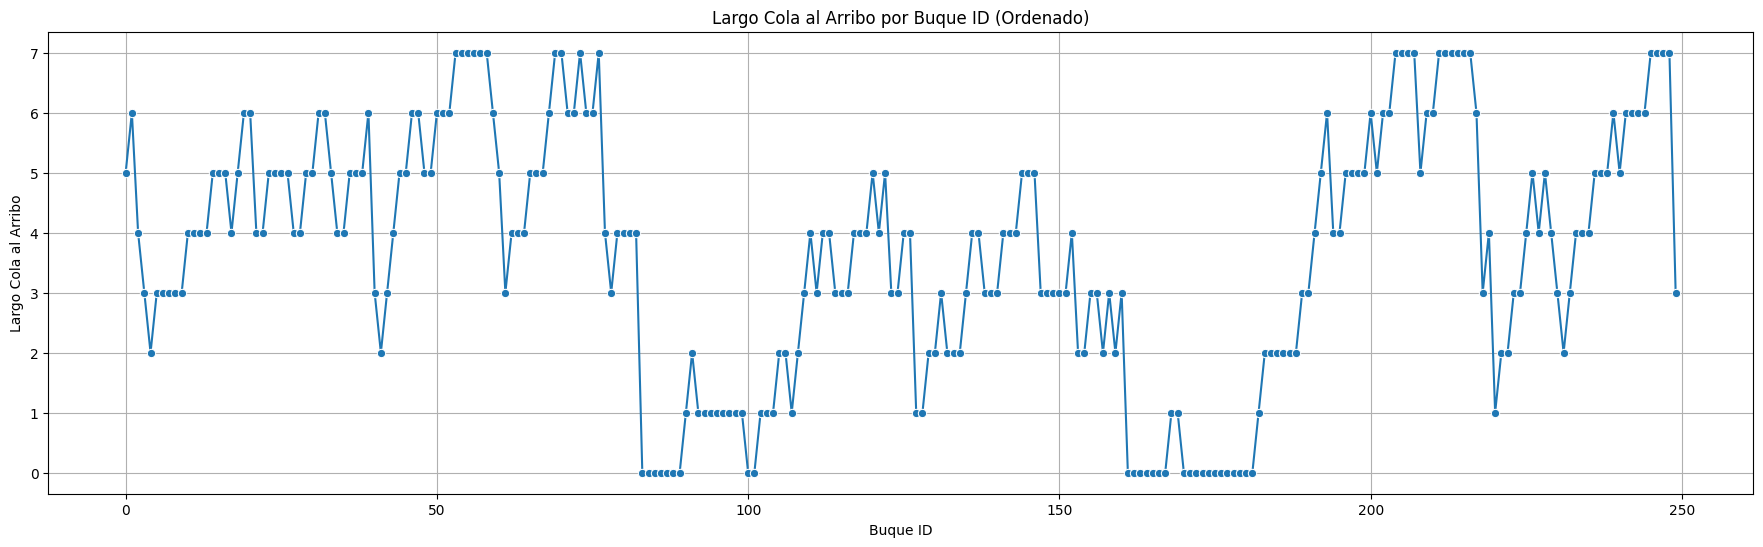

In [21]:
plt.figure(figsize=(22, 6))
sns.lineplot(data=df_buques.sort_values(by='BuqueID'),
             x='BuqueID', y='Largo cola al arribo', marker='o')
plt.title('Largo Cola al Arribo por Buque ID (Ordenado)')
plt.xlabel('Buque ID')
plt.ylabel('Largo Cola al Arribo')
plt.grid(True)
plt.show()

In [22]:
print(int(df_buques_col['Camiones normales'].sum()))
print(int(df_buques['Tonelaje buque'].sum()))

337861
9743292


**Tabla descriptiva Cola de Buques  -- Simulación con 0 dedicados:**

In [23]:
df_cola.describe(percentiles=[])

,Dia,Largo cola rada,total buques atendidos,total buques perdidos
count,1094.000000,1094.000000,1094.000000,1094.000000
mean,547.500000,4.858318,131.455210,4.582267
std,315.954902,2.422266,73.258003,2.732023
min,1.000000,0.000000,0.000000,0.000000
50%,547.500000,5.000000,135.000000,5.000000
max,1094.000000,9.000000,257.000000,10.000000



### **3.2 Histogramas simulación**





Se muestran histogramas de comparación entre los datos históricos y los resultados de la simulación sin camiones dedicados.

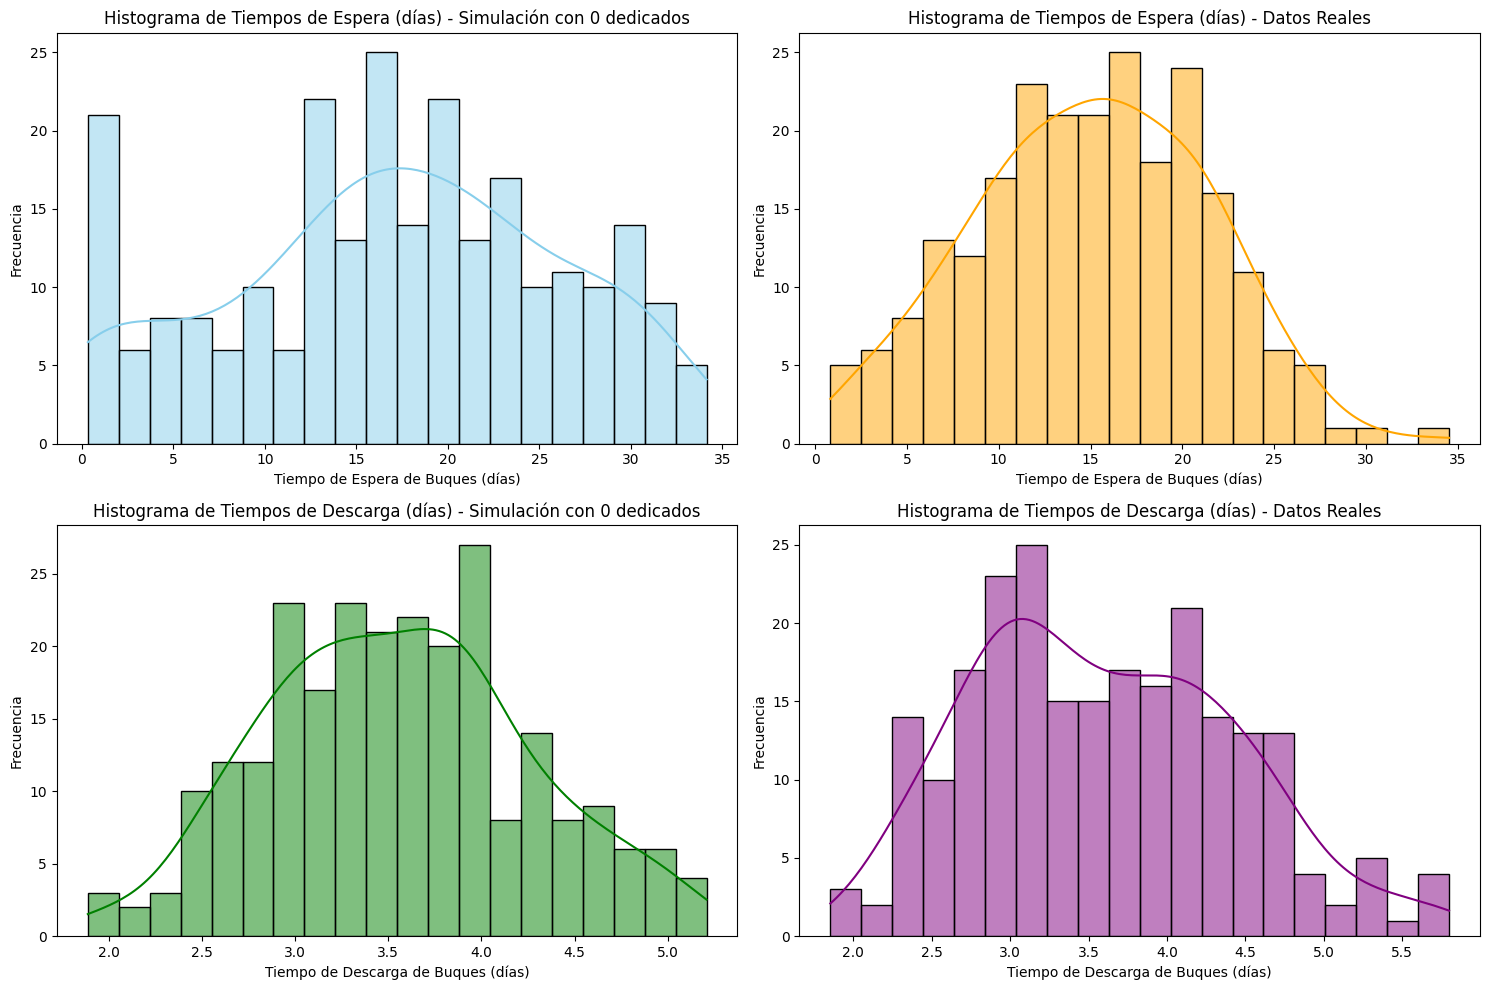

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tiempos de espera - Sim vs Real
sns.histplot(df_buques['Tiempo de espera (dias)'], bins=20,
             kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title(
    f'Histograma de Tiempos de Espera (días) - Simulación con {0} dedicados', fontsize=12)
axes[0, 0].set_xlabel('Tiempo de Espera de Buques (días)', fontsize=10)
axes[0, 0].set_ylabel('Frecuencia', fontsize=10)

sns.histplot(buques['Dias_de_espera_buque'], bins=20,
             kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title(
    'Histograma de Tiempos de Espera (días) - Datos Reales', fontsize=12)
axes[0, 1].set_xlabel('Tiempo de Espera de Buques (días)', fontsize=10)
axes[0, 1].set_ylabel('Frecuencia', fontsize=10)

# Tiempos de descarga - Sim vs Real
sns.histplot(df_buques['Tiempo descarga (dias)'], bins=20,
             kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title(
    f'Histograma de Tiempos de Descarga (días) - Simulación con {0} dedicados', fontsize=12)
axes[1, 0].set_xlabel('Tiempo de Descarga de Buques (días)', fontsize=10)
axes[1, 0].set_ylabel('Frecuencia', fontsize=10)

sns.histplot(buques['Dias_de_descarga_buque'], bins=20,
             kde=True, color='purple', ax=axes[1, 1])
axes[1, 1].set_title(
    'Histograma de Tiempos de Descarga (días) - Datos Reales', fontsize=12)
axes[1, 1].set_xlabel('Tiempo de Descarga de Buques (días)', fontsize=10)
axes[1, 1].set_ylabel('Frecuencia', fontsize=10)

plt.tight_layout()
plt.show()

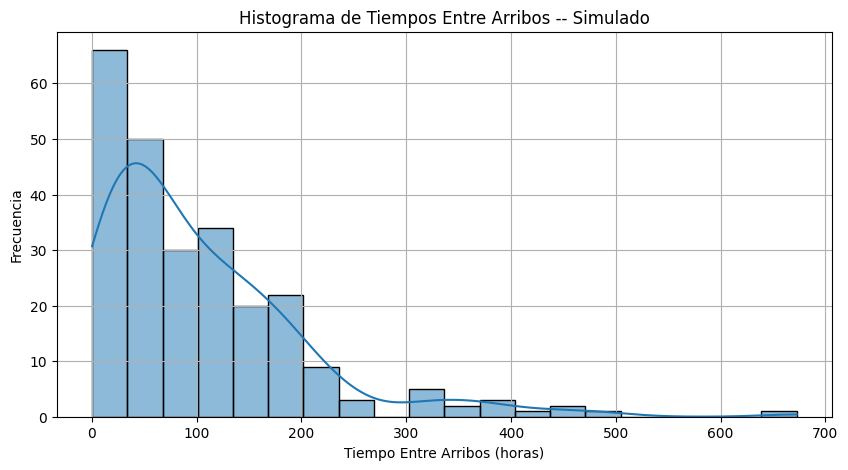

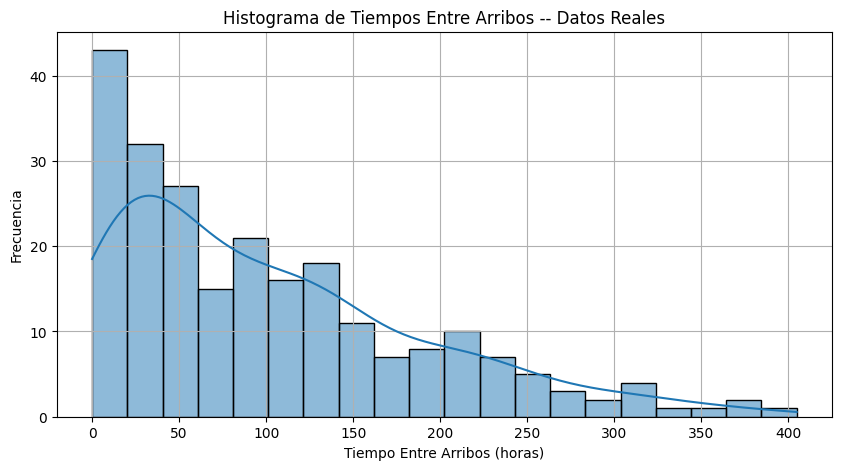

In [25]:
plt.figure(figsize=(10, 5))
df_buques['Horas entre arribos'] = (df_buques['Arribo'].diff().dropna())/60
sns.histplot(df_buques['Horas entre arribos'], bins=20, kde=True)
plt.title('Histograma de Tiempos Entre Arribos -- Simulado')
plt.xlabel('Tiempo Entre Arribos (horas)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 5))
sns.histplot(buques['horas_entre_arribos'], bins=20, kde=True)
plt.title('Histograma de Tiempos Entre Arribos -- Datos Reales')
plt.xlabel('Tiempo Entre Arribos (horas)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

### **3.3 Grafico largo de cola de buques en la rada**

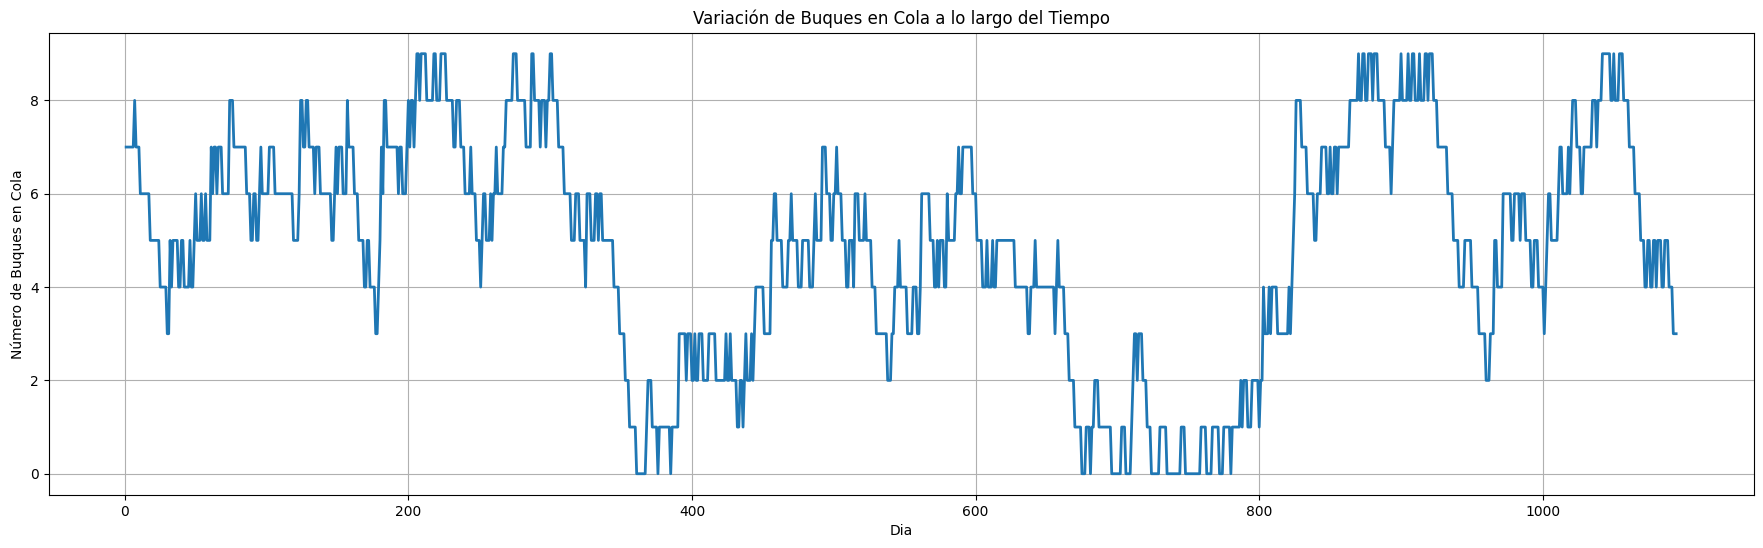

In [26]:

plt.figure(figsize=(22, 6))
df_cola['semana'] = df_cola['Dia'] // 7
sns.lineplot(data=df_cola, x='Dia', y='Largo cola rada', linewidth=2)
plt.title('Variación de Buques en Cola a lo largo del Tiempo')
plt.xlabel('Dia')
plt.ylabel('Número de Buques en Cola')
plt.grid(True)
plt.show()

### Diez años sin Camiones Dedicados

Datos de los buques reales:


,horas_de_espera,horas_de_descarga,horas_detencion,horas_entre_arribos,horas_falta_equipos,Dias_de_espera_buque,Dias_de_descarga_buque,Dias_detencion_buque,Dias_entre_arribos_buque,Dias_falta_equipos_buque
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,362.310755,86.327991,16.672723,101.633689,82.556197,15.096281,3.597000,0.694697,4.234737,3.439842
std,151.415753,20.102041,10.592429,88.098994,50.748273,6.308990,0.837585,0.441351,3.670791,2.114511
min,20.000000,44.500000,3.464444,0.000000,1.216667,0.833333,1.854167,0.144352,0.000000,0.050694
25%,259.170833,70.604167,9.648819,27.429167,44.675000,10.798785,2.941840,0.402034,1.142882,1.861458
50%,368.141667,83.958333,13.226250,80.208333,73.458333,15.339236,3.498264,0.551094,3.342014,3.060764
75%,475.212500,101.000000,19.651111,145.012500,113.537500,19.800521,4.208333,0.818796,6.042188,4.730729
max,828.500000,139.166667,55.658056,404.750000,278.300000,34.520833,5.798611,2.319086,16.864583,11.595833


Datos de los buques sim:


,Tonelaje buque,Camiones normales,Tiempo de espera (dias),Tiempo descarga (dias),Tiempo de espera (horas),Tiempo descarga (horas)
count,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000
mean,38714.573099,1342.405236,16.588263,3.531246,398.118317,84.749902
std,7389.087045,256.062976,9.505726,0.711814,228.137428,17.083536
min,21022.800000,728.000000,0.320833,1.838694,7.700000,44.128667
25%,32990.180000,1145.000000,8.907210,2.999877,213.773028,71.997046
50%,38765.270000,1344.000000,16.634212,3.493199,399.221091,83.836778
75%,42615.405000,1477.000000,24.363880,3.958103,584.733120,94.994470
max,55432.070000,1924.000000,36.638038,5.266342,879.312915,126.392218


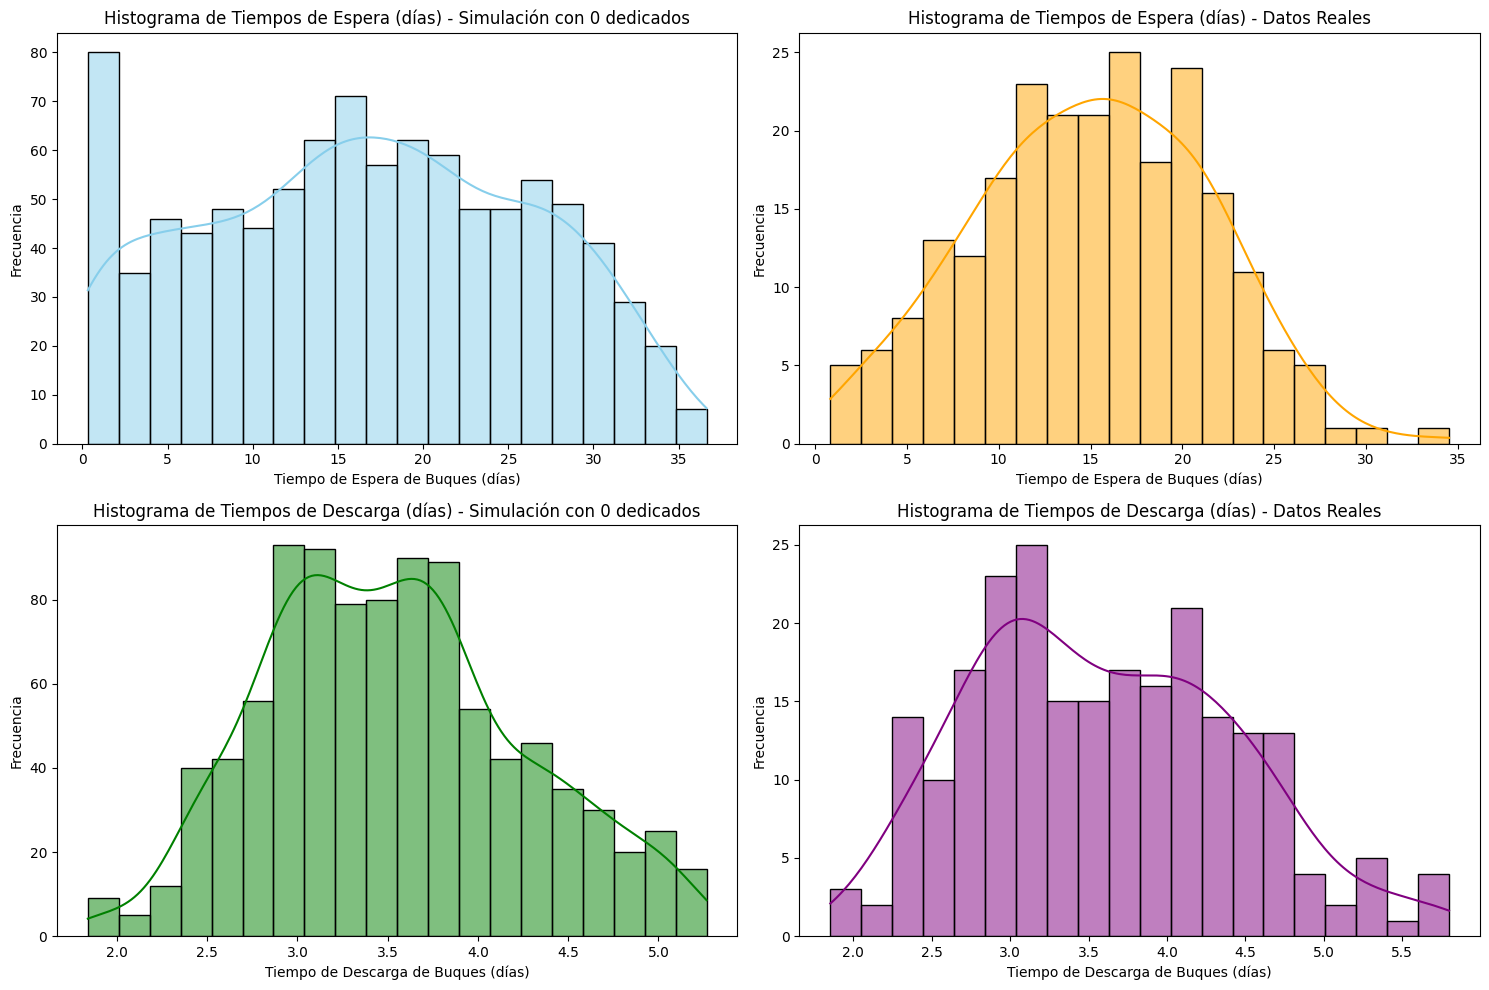

In [27]:

df_buques_v2, df_cola_v2 = simulacion(
    años=11, camiones_dedicados=0, seed=42)

print('Datos de los buques reales:')
display(buques[['horas_de_espera', 'horas_de_descarga', 'horas_detencion',
                'horas_entre_arribos', 'horas_falta_equipos', 'Dias_de_espera_buque',
        'Dias_de_descarga_buque', 'Dias_detencion_buque',
                'Dias_entre_arribos_buque', 'Dias_falta_equipos_buque']].describe())


print('Datos de los buques sim:')
df_buques_v2_col = df_buques_v2[['Tonelaje buque', 'Camiones normales', 'Tiempo de espera (dias)',
                                 'Tiempo descarga (dias)', 'Tiempo de espera (horas)', 'Tiempo descarga (horas)']]
display(df_buques_v2_col.describe())

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tiempos de espera - Sim vs Real
sns.histplot(df_buques_v2['Tiempo de espera (dias)'], bins=20,
             kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title(
    f'Histograma de Tiempos de Espera (días) - Simulación con {0} dedicados', fontsize=12)
axes[0, 0].set_xlabel('Tiempo de Espera de Buques (días)', fontsize=10)
axes[0, 0].set_ylabel('Frecuencia', fontsize=10)

sns.histplot(buques['Dias_de_espera_buque'], bins=20,
             kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title(
    'Histograma de Tiempos de Espera (días) - Datos Reales', fontsize=12)
axes[0, 1].set_xlabel('Tiempo de Espera de Buques (días)', fontsize=10)
axes[0, 1].set_ylabel('Frecuencia', fontsize=10)

# Tiempos de descarga - Sim vs Real
sns.histplot(df_buques_v2['Tiempo descarga (dias)'], bins=20,
             kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title(
    f'Histograma de Tiempos de Descarga (días) - Simulación con {0} dedicados', fontsize=12)
axes[1, 0].set_xlabel('Tiempo de Descarga de Buques (días)', fontsize=10)
axes[1, 0].set_ylabel('Frecuencia', fontsize=10)

sns.histplot(buques['Dias_de_descarga_buque'], bins=20,
             kde=True, color='purple', ax=axes[1, 1])
axes[1, 1].set_title(
    'Histograma de Tiempos de Descarga (días) - Datos Reales', fontsize=12)
axes[1, 1].set_xlabel('Tiempo de Descarga de Buques (días)', fontsize=10)
axes[1, 1].set_ylabel('Frecuencia', fontsize=10)

plt.tight_layout()
plt.show()



## **4. Simulación con Camiones Dedicados**





### **Parametros de Camiones dedicados y bodega**

In [28]:
num_con_camiones = 20
capacidad_camion_dedicado = 30
probabilidad_bodega = 0.1
grano_inicial_bodega = 1000
años_simulacion = 3
buques_inicio_cola = 7

df_buques_sim, df_cola_rada, df_bodega_sim = simulacion(
    años=3,
    camiones_dedicados=num_con_camiones,
    grano=grano_inicial_bodega,
    cap=capacidad_camion_dedicado,
    prob=probabilidad_bodega,
    buques_inicio_cola=buques_inicio_cola,
    seed=33
)

print('Parametros elegidos:')
print(f'camiones dedicados: {num_con_camiones}')
print(f'tiempo de simulacion: {años_simulacion}')
print(f'capacidad de los camiones dedicados: {capacidad_camion_dedicado}')
print(f'probabilidad de camiones a bodega: {probabilidad_bodega}')
print(f'grano inicial en bodega: {grano_inicial_bodega}')

print('-------------------------------------------------------')
print('Resultados Simulacion')
a = df_buques_sim['Camiones normales'].sum()
b = df_buques_sim['Camiones dedicados'].sum()
c = a+b
print(f'camiones totales: {c}')
print(f'camiones normales: {a}')
print(f'camiones dedicados: {b}')
print('numero de buques atendidos', int(df_buques_sim['BuqueID'].count()))

print('suma tonelajes buques atendidos', int(
    df_buques_sim['Tonelaje buque'].sum()))

Parametros elegidos:
camiones dedicados: 20
tiempo de simulacion: 3
capacidad de los camiones dedicados: 30
probabilidad de camiones a bodega: 0.1
grano inicial en bodega: 1000
-------------------------------------------------------
Resultados Simulacion
camiones totales: 381603
camiones normales: 307867
camiones dedicados: 73736
numero de buques atendidos 290
suma tonelajes buques atendidos 11089246



### **Tablas resultados simulacion**

-  **Tabla Buques:** con camiones dedicados

In [29]:

display(df_buques_sim.head(10))
display(df_buques_sim.describe())

,BuqueID,Largo cola al arribo,Tonelaje buque,Arribo,Tiempo de espera (dias),Tiempo descarga (dias),Camiones normales,Camiones dedicados,Tiempo de espera (horas),Tiempo descarga (horas)
0,0,5,32180.81,4705.115955,19.868322,2.415819,863,242,476.839734,57.979667
1,1,6,25890.37,4819.309591,22.650674,1.778625,763,130,543.616173,42.687000
2,2,7,34546.89,6354.498566,23.822918,2.509288,949,238,571.750024,60.222923
3,3,7,41625.30,8922.645678,24.987660,2.911392,1200,234,599.703829,69.873410
4,4,7,43737.75,13679.493658,25.159574,3.084271,1241,266,603.829772,74.022511
5,5,6,41161.96,23115.808226,22.115849,2.959740,1143,272,530.780374,71.033755
6,6,7,44117.15,23334.107129,25.383714,3.159614,1235,286,609.209148,75.830733
7,7,6,37244.20,33211.196652,22.178683,2.713736,1043,239,532.288389,65.129667
8,8,4,49459.15,45880.230549,16.491701,3.621333,1368,334,395.800824,86.912000
9,9,5,47398.63,46044.631922,20.455117,3.454861,1291,339,490.922801,82.916667


,BuqueID,Largo cola al arribo,Tonelaje buque,Arribo,Tiempo de espera (dias),Tiempo descarga (dias),Camiones normales,Camiones dedicados,Tiempo de espera (horas),Tiempo descarga (horas)
count,290.000000,290.000000,290.000000,2.900000e+02,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
mean,144.500000,2.382759,38238.782345,7.704903e+05,9.520990,2.763502,1061.610345,254.262069,228.503770,66.324045
std,83.860002,2.177674,7769.573202,4.508522e+05,7.347787,0.575324,213.349065,61.109185,176.346885,13.807785
min,0.000000,0.000000,21566.230000,4.705116e+03,0.320833,1.526042,586.000000,112.000000,7.700000,36.625000
25%,72.250000,0.000000,32682.025000,4.166209e+05,3.316228,2.328924,902.000000,207.000000,79.589468,55.894174
50%,144.500000,2.000000,37875.600000,7.612178e+05,8.034384,2.726889,1051.000000,244.500000,192.825205,65.445333
75%,216.750000,4.000000,43270.130000,1.161922e+06,14.808800,3.131480,1208.250000,294.000000,355.411206,75.155519
max,289.000000,7.000000,55432.070000,1.563609e+06,26.203887,4.046875,1527.000000,414.000000,628.893295,97.125000


- **Tabla Bodega:** con camiones dedicados

    cada vez que un camion carga o descarga grano en la bodega, se registra un evento en la tabla de eventos de la bodega.

In [30]:
display(df_bodega_sim.describe())

,horas en cola bodega,horas de descarga en bodega,horas de carga en bodega,tons depositadas en bodega,tons retiradas de bodega,ton restante bodega
count,166235.000000,166235.000000,166235.000000,166235.000000,166235.000000,166235.000000
mean,3637.726122,0.045403,0.138996,13.615133,13.621148,35.631651
std,4439.056207,0.049788,2.107675,14.933949,14.110867,33.374882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,6.380000
50%,1012.599044,0.000000,0.100000,0.000000,3.540000,31.400000
75%,6513.750127,0.100000,0.100000,30.000000,28.860000,49.495000
max,14320.598409,0.100000,526.536722,30.000000,32.360000,1121.610000


- **Tabla Cola de Buques:** con camiones dedicados

In [31]:

display(df_cola_rada.describe())

,Dia,Largo cola rada,total buques atendidos,total buques perdidos
count,1094.000000,1094.000000,1094.000000,1094.000000
mean,547.500000,3.375686,151.919561,9.404022
std,315.954902,2.485197,85.862903,1.154736
min,1.000000,0.000000,0.000000,0.000000
25%,274.250000,1.000000,73.000000,9.000000
50%,547.500000,3.000000,156.000000,10.000000
75%,820.750000,5.000000,226.000000,10.000000
max,1094.000000,9.000000,297.000000,10.000000




### **Histogramas Buques Simulacion**



Comparamos los histogramas de tiempos de espera y de descarga simulados contra los datos reales.



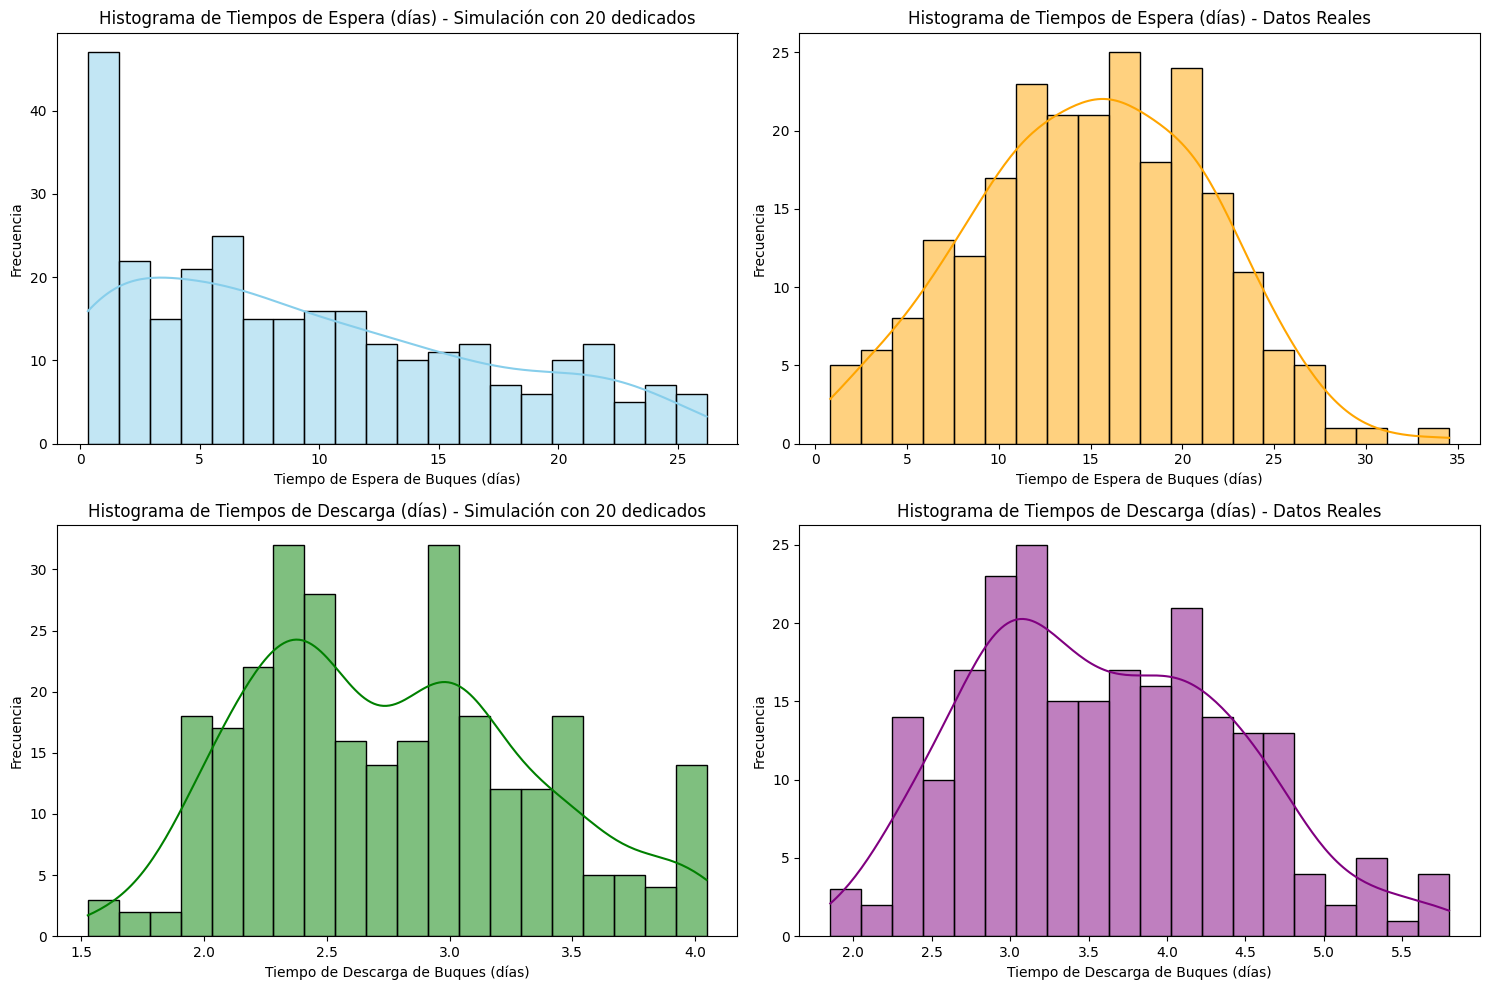

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tiempos de espera - Sim vs Real
sns.histplot(df_buques_sim['Tiempo de espera (dias)'],
             bins=20, kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title(
    f'Histograma de Tiempos de Espera (días) - Simulación con {num_con_camiones} dedicados', fontsize=12)
axes[0, 0].set_xlabel('Tiempo de Espera de Buques (días)', fontsize=10)
axes[0, 0].set_ylabel('Frecuencia', fontsize=10)

sns.histplot(buques['horas_de_espera'] / 24, bins=20,
             kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title(
    'Histograma de Tiempos de Espera (días) - Datos Reales', fontsize=12)
axes[0, 1].set_xlabel('Tiempo de Espera de Buques (días)', fontsize=10)
axes[0, 1].set_ylabel('Frecuencia', fontsize=10)

# Tiempos de descarga - Sim vs Real
sns.histplot(df_buques_sim['Tiempo descarga (dias)'],
             bins=20, kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title(
    f'Histograma de Tiempos de Descarga (días) - Simulación con {num_con_camiones} dedicados', fontsize=12)
axes[1, 0].set_xlabel('Tiempo de Descarga de Buques (días)', fontsize=10)
axes[1, 0].set_ylabel('Frecuencia', fontsize=10)

sns.histplot(buques['horas_de_descarga'] / 24, bins=20,
             kde=True, color='purple', ax=axes[1, 1])
axes[1, 1].set_title(
    'Histograma de Tiempos de Descarga (días) - Datos Reales', fontsize=12)
axes[1, 1].set_xlabel('Tiempo de Descarga de Buques (días)', fontsize=10)
axes[1, 1].set_ylabel('Frecuencia', fontsize=10)

plt.tight_layout()
plt.show()

### **Grafico Cola de buques en rada**

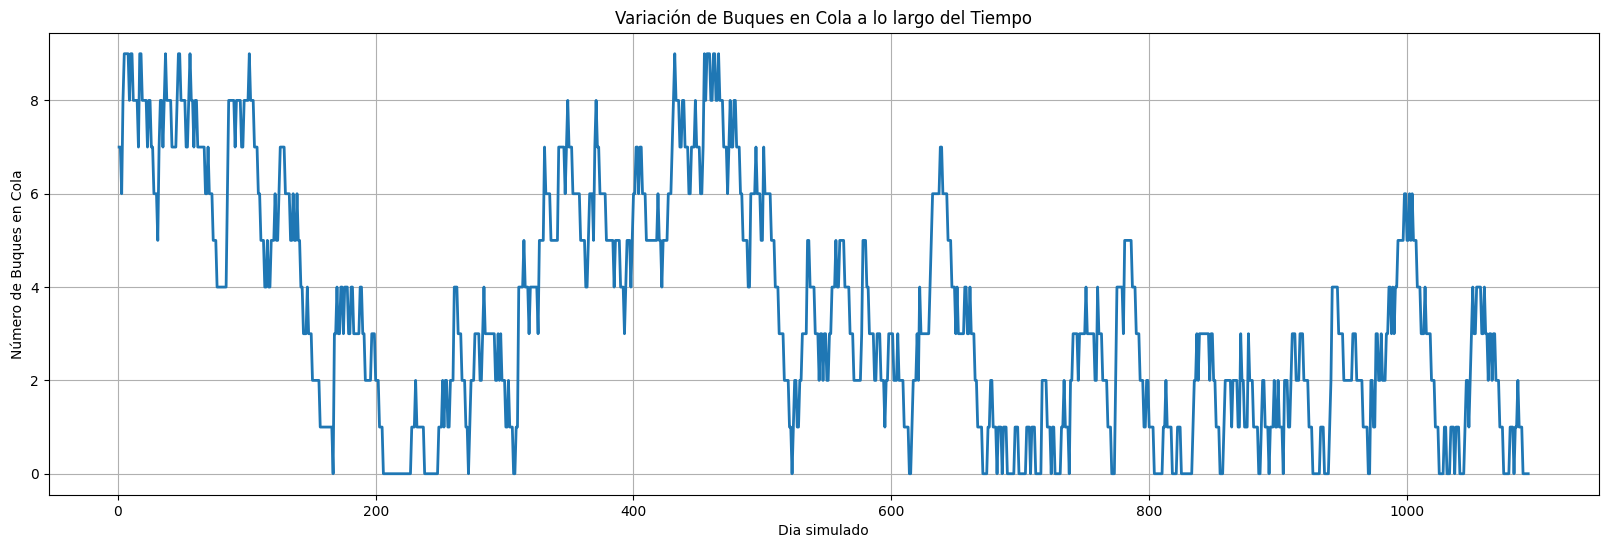

In [33]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_cola_rada, x='Dia', y='Largo cola rada', linewidth=2)
plt.title('Variación de Buques en Cola a lo largo del Tiempo')
plt.xlabel('Dia simulado')
plt.ylabel('Número de Buques en Cola')
plt.grid(True)
plt.show()

### **Grafico Ocupacion de Bodega**

In [34]:
df_bodega_sim

,id_camion,horas en cola bodega,horas de descarga en bodega,horas de carga en bodega,actividad camion,tons depositadas en bodega,tons retiradas de bodega,ton restante bodega
0,Dedicado0,0.000000,0.1,0.0,descargar en bodega,30.00,0.00,1030.00
1,Dedicado1,0.100000,0.1,0.0,descargar en bodega,30.00,0.00,1060.00
2,Dedicado2,0.200000,0.1,0.0,descargar en bodega,30.00,0.00,1090.00
3,Dedicado3,0.300000,0.1,0.0,descargar en bodega,30.00,0.00,1120.00
4,Bodega0,0.000000,0.0,0.1,cargar en bodega,0.00,28.72,1091.28
...,...,...,...,...,...,...,...,...
166230,Dedicado7,0.050000,0.1,0.0,descargar en bodega,30.00,0.00,38.38
166231,Dedicado5,0.075000,0.1,0.0,descargar en bodega,20.96,0.00,59.34
166232,Bodega90756,14320.413439,0.0,0.1,cargar en bodega,0.00,29.17,30.17
166233,Bodega90757,14320.503704,0.0,0.1,cargar en bodega,0.00,29.42,0.75


In [35]:
df_bodega_sim.reset_index(drop=False, inplace=True)
df_bodega_sim.rename(columns={'index': 'ID'}, inplace=True)

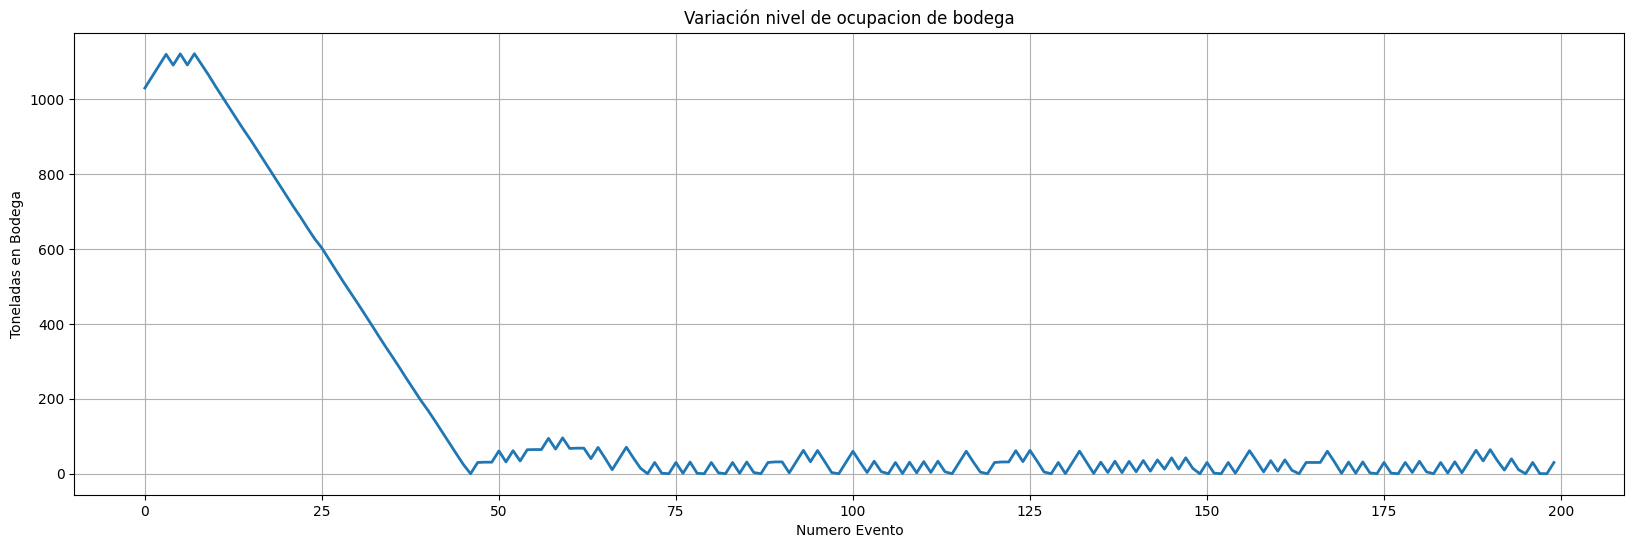

In [36]:
df_bodega_sim1 = df_bodega_sim.iloc[0:200]

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_bodega_sim1, x='ID', y='ton restante bodega', linewidth=2)
plt.title('Variación nivel de ocupacion de bodega')
plt.xlabel('Numero Evento')
plt.ylabel('Toneladas en Bodega')
plt.grid(True)
plt.show()

## **5. Funcion final simulaciones**

#### simulacion_testing

In [37]:


def simulacion_testing(Lista_tupla):
    i = 0
    for tupla in Lista_tupla:
        i += 1
        n_dedicados, capacidad_dedicados, probabilidad_bodega, grano_inicial_bodega, años_simulacion, buques_inicio_cola, semilla = tupla
        buqes_df, rada_df, bodega_df = simulacion(
            años=años_simulacion,
            camiones_dedicados=n_dedicados,
            grano=grano_inicial_bodega,
            cap=capacidad_dedicados,
            prob=probabilidad_bodega,
            buques_inicio_cola=buques_inicio_cola,
            seed=semilla
        )
        bodega_df.reset_index(drop=False, inplace=True)
        bodega_df.rename(columns={'index': 'ID'}, inplace=True)

        print(
            f'------------------------ SIMULACION {i}  -----------------------')

        print('---------- Parametros ---------')
        print(f'Camiones Dedicados: {n_dedicados}')
        print(f'Tiempo de simulacion (años): {años_simulacion}')
        print(f'Capacidad de los Camiones Dedicados: {capacidad_dedicados}')
        print(f'Probabilidad de Camiones a bodega: {probabilidad_bodega}')
        print(f'Toneladas en bodega iniciales: {grano_inicial_bodega}')

        print(' ')
        print('--------------- Resultados  ------------')
        print('Buques atendidos', int(buqes_df['BuqueID'].count()))
        print('Tiempo promedio de espera (días)',
              buqes_df['Tiempo de espera (dias)'].mean())
        print('Tiempo promedio de descarga (días)',
              buqes_df['Tiempo descarga (dias)'].mean())
        print('Largo de la cola de buques promedio',
              rada_df['Largo cola rada'].mean())
        print('Tonelaje promedio en bodega',
              bodega_df['ton restante bodega'].mean())
        print('Cantidad de camiones que cargaron en bodega', int(
            bodega_df[bodega_df['actividad camion '] == 'cargar en bodega']['ID'].count()))
        print('Cantidad de camiones que descargaron en bodega', int(
            bodega_df[bodega_df['actividad camion '] == 'descargar en bodega']['ID'].count()))
        a = buqes_df['Camiones normales'].sum()
        b = buqes_df['Camiones dedicados'].sum()
        c = a+b
        print(f'Camiones totales: {c}')
        print(f'Camiones normales: {a}')
        print('Suma tonelajes buques atendidos', int(
            buqes_df['Tonelaje buque'].sum()))

        print(' ')
        print('------------ Graficos  ----------')

        plt.figure(figsize=(20, 12))

        sns.histplot(buqes_df['Tiempo de espera (dias)'],
                     bins=20, kde=True, color='skyblue')
        plt.title(
            f'Histograma de Tiempos de Espera (días) - Simulación con {n_dedicados} dedicados', fontsize=12)
        plt.xlabel('Tiempo de Espera de Buques (días)')
        plt.ylabel('Frecuencia')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(20, 12))

        sns.histplot(buqes_df['Tiempo descarga (dias)'],
                     bins=20, kde=True, color='green')
        plt.title(
            f'Histograma de Tiempos de Descarga (días) - Simulación con {n_dedicados} dedicados', fontsize=12)
        plt.xlabel(
            'Tiempo de Descarga de Buques (días)')
        plt.ylabel('Frecuencia')
        plt.grid(True)

        plt.show()

        plt.figure(figsize=(20, 12))
        sns.lineplot(data=rada_df, x='Dia', y='Largo cola rada', linewidth=2)
        plt.title('Variación de Buques en Cola a lo largo del Tiempo')
        plt.xlabel('Dia simulado')
        plt.ylabel('Número de Buques en Cola')
        plt.grid(True)
        plt.show()

        rada_df2 = rada_df.iloc[-200:]
        plt.figure(figsize=(20, 12))
        sns.lineplot(data=rada_df2, x='Dia', y='Largo cola rada', linewidth=2)
        plt.title(
            'Ultimos 200 dias - Variación de Buques en Cola a lo largo del Tiempo')
        plt.xlabel('Dia simulado')
        plt.ylabel('Número de Buques en Cola')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(20, 12))
        sns.lineplot(data=bodega_df, x='ID',
                     y='ton restante bodega', linewidth=2)
        plt.title('Variación nivel de ocupacion de bodega')
        plt.xlabel('Numero Evento')
        plt.ylabel('Toneladas en Bodega')
        plt.grid(True)
        plt.show()

        bodega_df2 = bodega_df.iloc[0:500]

        plt.figure(figsize=(20, 12))
        sns.lineplot(data=bodega_df2, x='ID',
                     y='ton restante bodega')
        plt.title(
            f'Primeros 500 eventos - Nivel de ocupacion de bodega ({grano_inicial_bodega} toneladas iniciales)')
        plt.xlabel('Numero Evento')
        plt.ylabel('Toneladas en Bodega')
        plt.grid(True)
        plt.show()
        bodega_df3 = bodega_df.iloc[-500:]

        plt.figure(figsize=(20, 12))
        sns.lineplot(data=bodega_df3, x='ID',
                     y='ton restante bodega')
        plt.title(
            f'Ultimos 500 eventos - Nivel de ocupacion de bodega ({grano_inicial_bodega} toneladas iniciales)')
        plt.xlabel('Numero Evento')
        plt.ylabel('Toneladas en Bodega')
        plt.grid(True)
        plt.show()

        print('-------------------------------------------------------')

#### resultados

In [38]:
# semilla = 2
# # tupla= (n_dedicados, capacidad_dedicados, probabilidad_bodega, grano_inicial_bodega, años_simulacion, buques_inicio_cola, semilla
# tupla1 = (10, 25, 0.1, 30, 2, 3, semilla)
# tupla2 = (15, 25, 0.1, 30, 2, 5, semilla)
# tupla3 = (20, 25, 0.1, 50, 2, 10, semilla)
# tupla4 = (20, 30, 0.1, 100, 2, 5, semilla)
# lista_tupla = [tupla1, tupla2, tupla3, tupla4]

# simulacion_testing(lista_tupla)

In [39]:
# num_con_camiones = 30
# capacidad_camion_dedicado = 30
# probabilidad_bodega = 0.1
# grano_inicial_bodega = 50
# años_simulacion = 5
# semilla=5

In [40]:

# semilla = 16
# # tupla= (n_dedicados, capacidad_dedicados, probabilidad_bodega, grano_inicial_bodega, años_simulacion, buques_inicio_cola, semilla
# tupla1 = (10, 25, 0.1, 30, 10, 0, semilla)
# tupla2 = (15, 25, 0.1, 30, 10, 5, semilla)
# tupla3 = (20, 25, 0.1, 50, 5, 10, semilla)
# tupla4 = (20, 30, 0.1, 100, 5, 5, semilla)
# lista_tupla = [tupla1, tupla2, tupla3, tupla4]

# simulacion_testing(lista_tupla)

In [41]:

# semilla = 16
# # tupla=n_dedicados, capacidad_dedicados, probabilidad_bodega, grano_inicial_bodega, buques_inicio_cola,años_simulacion,semilla
# tupla1 = (40, 27, 0.1, 50, 1, 5, semilla)
# tupla2 = (40, 27, 0.2, 100, 1, 0, semilla)
# tupla3 = (30, 30, 0.1, 300, 1, 10, semilla)
# tupla4 = (20, 30, 0.1, 1000, 1, 0, semilla)
# lista_tupla = [tupla1, tupla2, tupla3, tupla4]

# simulacion_testing(lista_tupla)


 **Conclusiones**

- El modelo de simulación presentado permite comparar de forma aproximada los tiempos de espera y descarga observados en datos históricos con los resultados simulados.
- Se pueden ajustar parámetros como la capacidad de la bodega, el número de camiones dedicados, la capacidad de dichos camiones y la probabilidad de envío de camiones a la bodega para buscar un mejor alineamiento con la realidad.
- se pueden encontrar configuraciones que reduzcan los tiempos de espera y descarga, optimizando los recursos del puerto.

**Nota:** Los resultados son sensibles a la calidad de los datos de entrada y a las simplificaciones realizadas en el modelo (por ejemplo, los horarios de colación,detenciones, las tasas de llegada de buques y camiones, etc.).

